# Correlation matrix without bw

In [1]:
import tfr_evaluate
import os
import pandas as pd
import util
import matplotlib.pyplot as plt
import seaborn as sns
import metrics
import numpy as np
import glob

In [2]:
def collect_data_and_model(model_path, testset_path):
    targets_path = os.path.join(testset_path, 'targets.txt')
    targets = pd.read_csv(targets_path, delimiter='\t')['identifier'].values
    sts = util.load_stats(testset_path)
    testset  = util.make_dataset(testset_path, 'test', sts, batch_size=512, shuffle=False)
    model, bin_size = tfr_evaluate.read_model(model_path, compile_model=False)
    metadata = tfr_evaluate.get_run_metadata(model_path)
    model_id = '{} {}'.format(metadata['model_fn'][0], bin_size)
    return testset, targets, model, bin_size, model_id

def get_mse_df(array_3d, targets):
    N,L,C = array_3d.shape
    flat_array = array_3d.reshape(N*L,C)
    pairwise_mse = {}
    for c1 in range(C):
        pairwise_mse[c1] = {}
        for c2 in range(C):
            mse = metrics.get_mse(flat_array[:,c1], flat_array[:,c2]).mean()
            pairwise_mse[c1][c2] = mse
    pairwise_mse_df = pd.DataFrame(pairwise_mse)
    pairwise_mse_df.columns = targets
    pairwise_mse_df.set_index(targets, inplace=True)
    return pairwise_mse_df

def plot_mse_matrices(mse_dfs, overall_title=''): 
#     plt.rcParams.update({'font.size': 16})
    fig, axs = plt.subplots(1, 3, figsize=[26, 8])
#     min_lim = pd.concat([v for _, v in mse_dfs.items()]).min().min() vmin=min_lim, vmax=1, 
    for i, (title, matrix) in enumerate(mse_dfs.items()):
        matrix_heatmap = sns.heatmap(matrix, annot=True,  ax=axs[i], cmap='flare', annot_kws={"fontsize":8})
        axs[i].set_title(title)    
    plt.suptitle(overall_title)
    plt.tight_layout()
    
def get_truth_pred_corr(data_model_info):
    testset, targets, model, bin_size, model_id = data_model_info
    # make whole test set prediction and save both gt and pred
    truth, pred = tfr_evaluate.get_true_pred(model, bin_size, testset)
    # get correlation df
    N,L,C = pred.shape
    truth_pred_corr_matrices = {}
    title_array_pairs = {'ground truth': truth, 'predictions of model {}'.format(model_id): pred}
    for title, array in title_array_pairs.items():
        array = array.reshape(N*L, C)
        truth_pred_corr_matrices[title] = pd.DataFrame(array).corr()
        truth_pred_corr_matrices[title].columns = targets
        truth_pred_corr_matrices[title].set_index(targets, inplace=True)
    avg_corr = [((truth_pred_corr_matrices[k]).mean()).mean() for k in truth_pred_corr_matrices.keys()]
    return truth_pred_corr_matrices, avg_corr

def plot_corr_matrices(corr_dfs):    
    fig, axs = plt.subplots(1, 2, figsize=[20, 8])
    min_lim = pd.concat([v for _, v in corr_dfs.items()]).min().min()
    for i, (title, matrix) in enumerate(corr_dfs.items()):
        matrix_heatmap = sns.heatmap(matrix, annot=True, vmin=min_lim, vmax=1,  ax=axs[i], cmap='flare')
        axs[i].set_title(title)    
    plt.tight_layout()
#     plt.savefig(os.path.join(outdir, 'correlation_matrices_{}_{}.svg'.format(set_type, model_id)))

def plot_model_corr(model_path, testset_path):
    truth_pred_corr_matrices, avg_corr = get_truth_pred_corr(collect_data_and_model(model_path, testset_path)) 
    plot_corr_matrices(truth_pred_corr_matrices)
    print('Average prediction correlation = {}'.format(avg_corr[1])) 

def get_truth_pred_mse(testset, targets, model, bin_size, model_id):
    truth, pred = tfr_evaluate.get_true_pred(model, bin_size, testset)
    scaling_factors = tfr_evaluate.get_scaling_factors(truth, pred)
    scaled_pred = pred * scaling_factors
    mse_matrices = {}
    mse_matrices['ground truth'] = get_mse_df(truth, targets)
    mse_matrices['scaled predictions'] = get_mse_df(scaled_pred, targets)
    mse_matrices['raw predictions'] = get_mse_df(pred, targets)
    return mse_matrices


def plot_model_mse(model_path, testset_path):
    testset, targets, model, bin_size, model_id = collect_data_and_model(model_path, testset_path)
    truth_pred_mse_matrices = get_truth_pred_mse(testset, targets, model, bin_size, model_id) 
    plot_mse_matrices(truth_pred_mse_matrices, model_id)

In [3]:
# load model and testset
testset_path = '/mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/shush/4grid_atac/complete/peak_centered/i_2048_w_1/'

Average prediction correlation = 0.7975657500099362


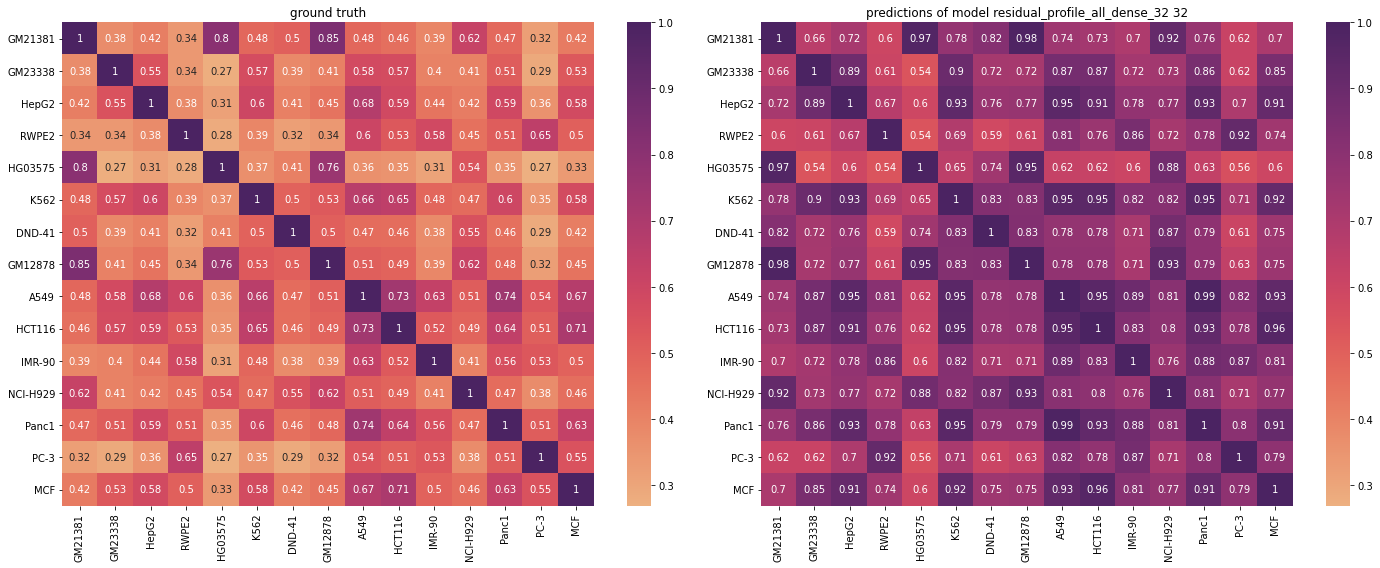

In [4]:
model_path = 'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01'
truth_pred_corr_matrices = plot_model_corr(model_path, testset_path)

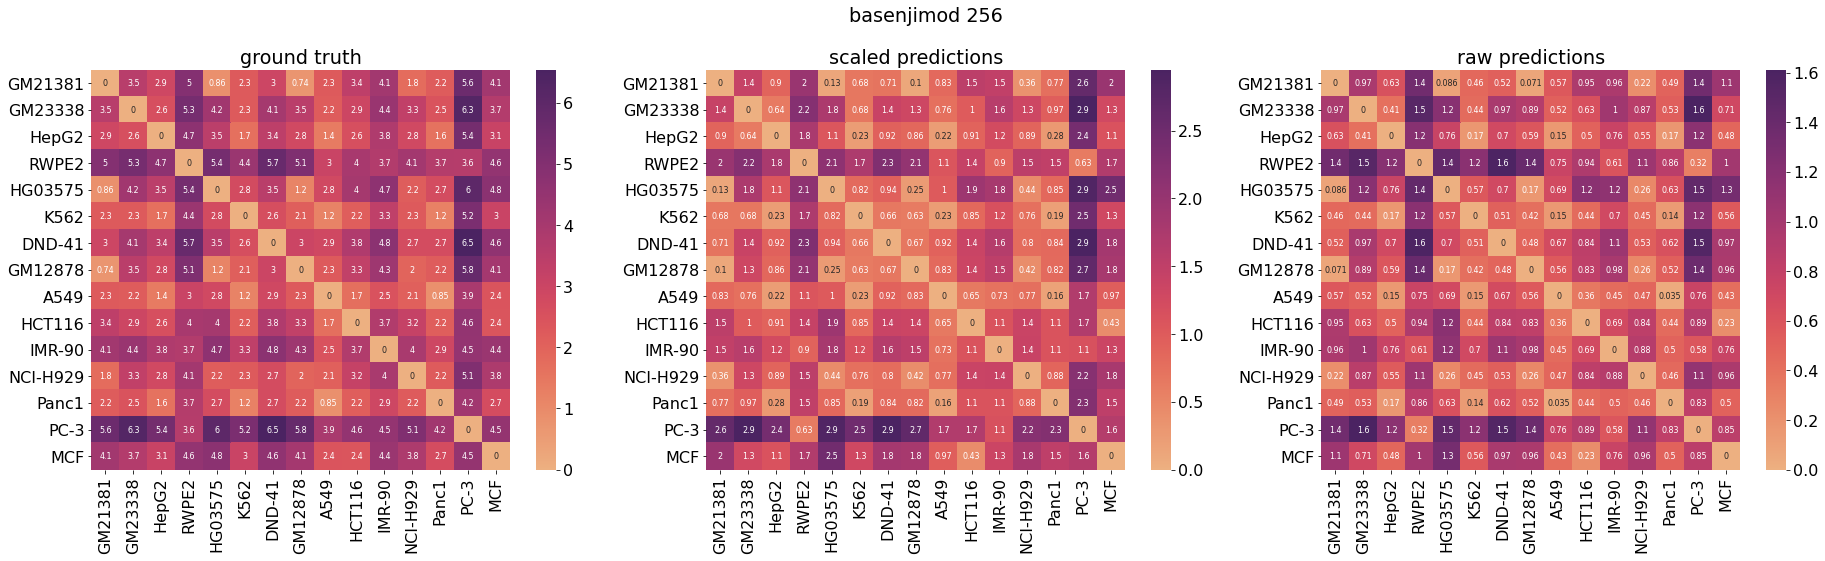

In [100]:
model_path = '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_elzar/run-20210923_162932-56p3xy2p'
plot_model_mse(model_path, testset_path)

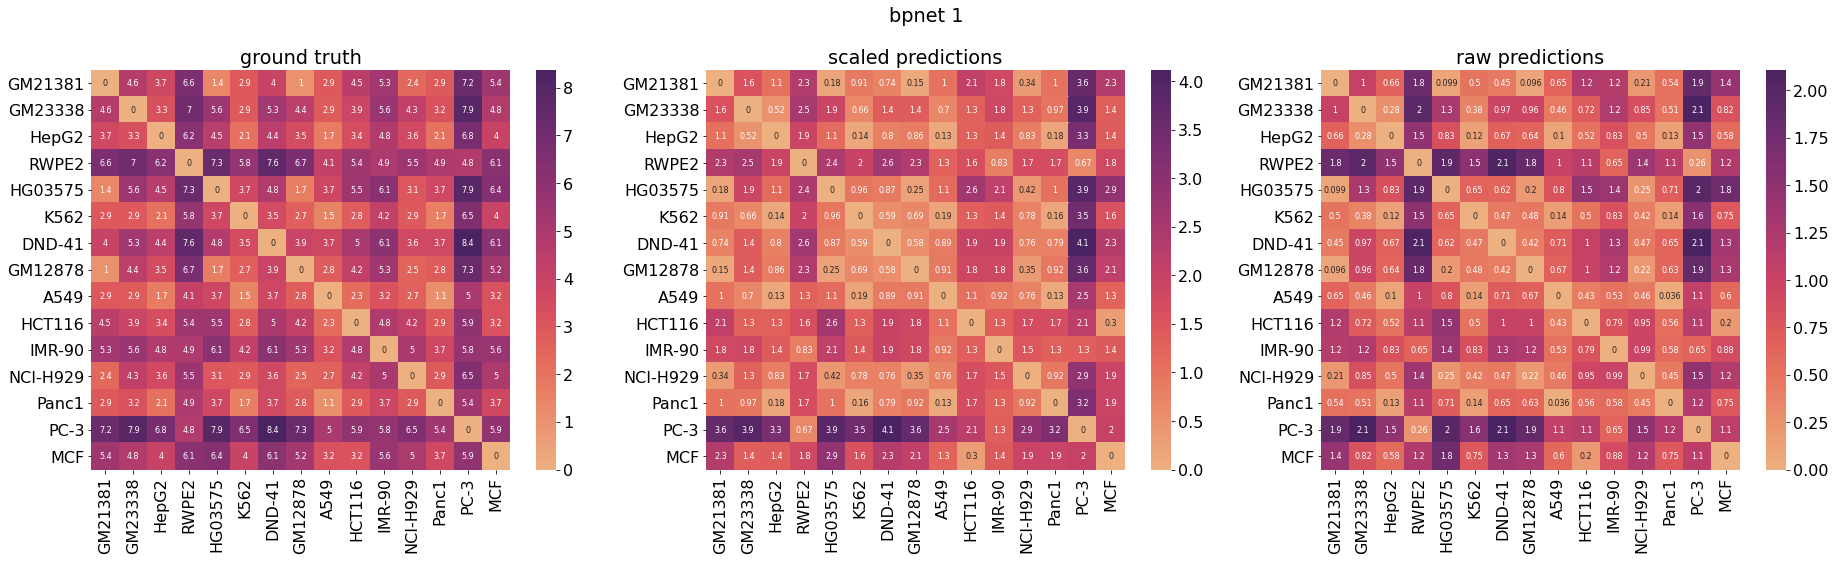

In [102]:
bpnet = 'paper_runs/bpnet/augmentation_48/run-20211006_033330-jyaynmpo'
plot_model_mse(bpnet, testset_path)

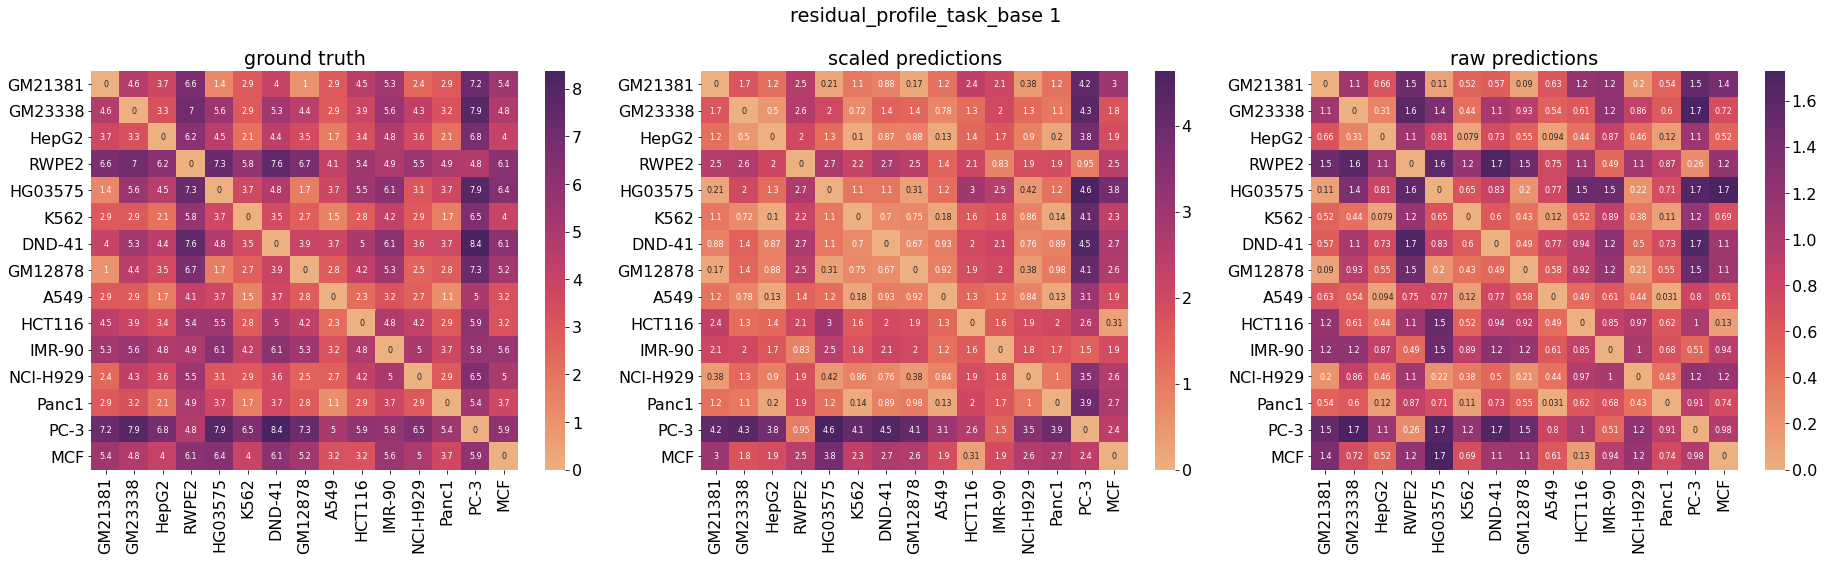

In [106]:
residual_profile_task_base_path = glob.glob('paper_runs/new_models/base_res/*yc4sh7qf')[0]
plot_model_mse(residual_profile_task_base_path, testset_path)

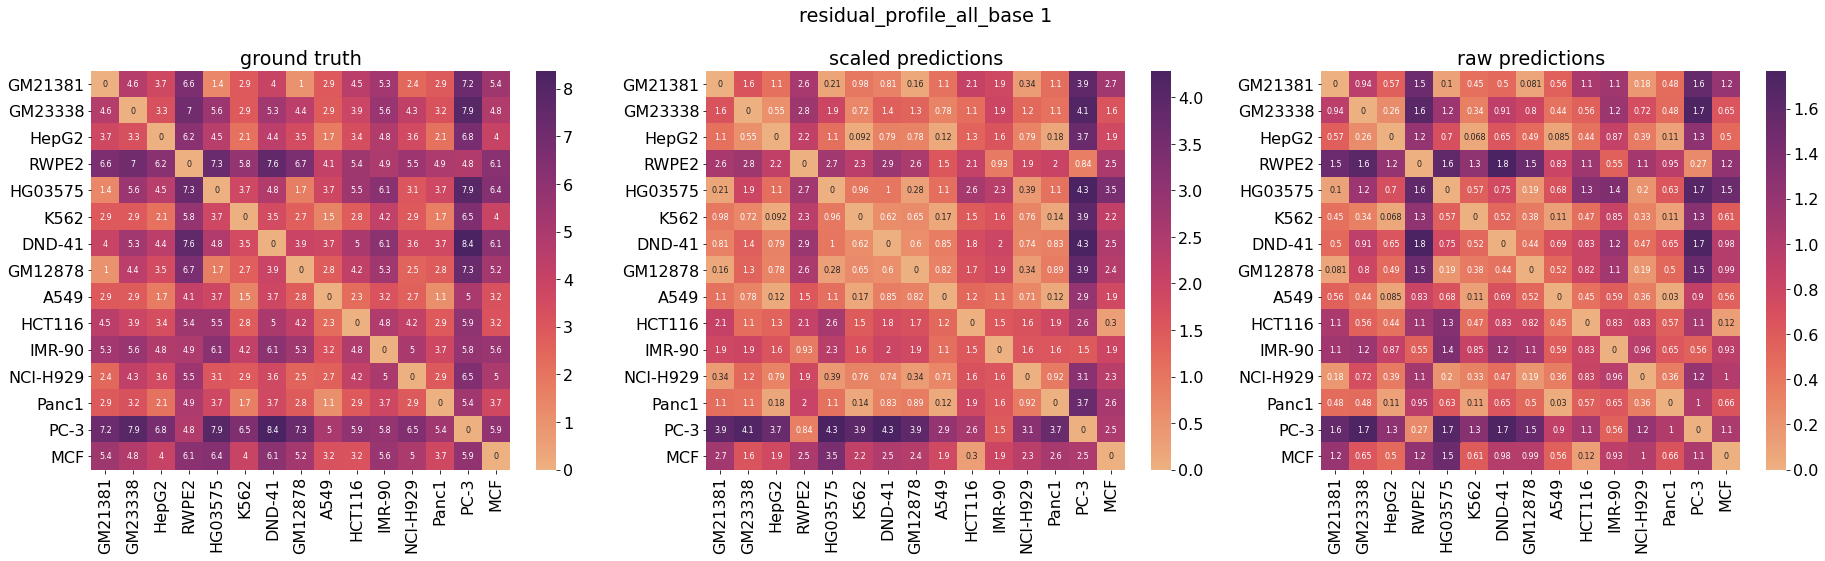

In [101]:
residual_profile_all_base_path = 'paper_runs/new_models/base_res/run-20211022_141032-m1cjyb3z'
plot_model_mse(residual_profile_all_base_path, testset_path)

# Pearson r 

Average prediction correlation = [0.5195269350614614, 0.8233488631593006]


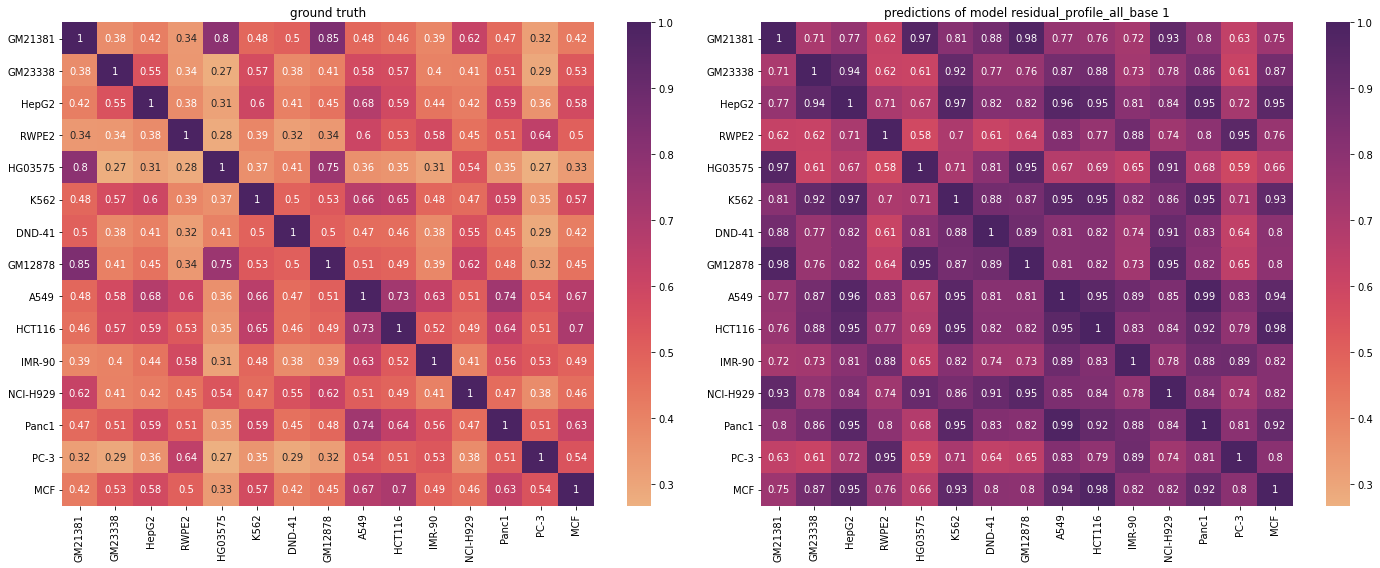

In [21]:
residual_profile_all_base_path = 'paper_runs/new_models/base_res/run-20211022_141032-m1cjyb3z'
truth_pred_corr_matrices = plot_model_corr(residual_profile_all_base_path, testset_path)

Average prediction correlation = 0.8176017399582969


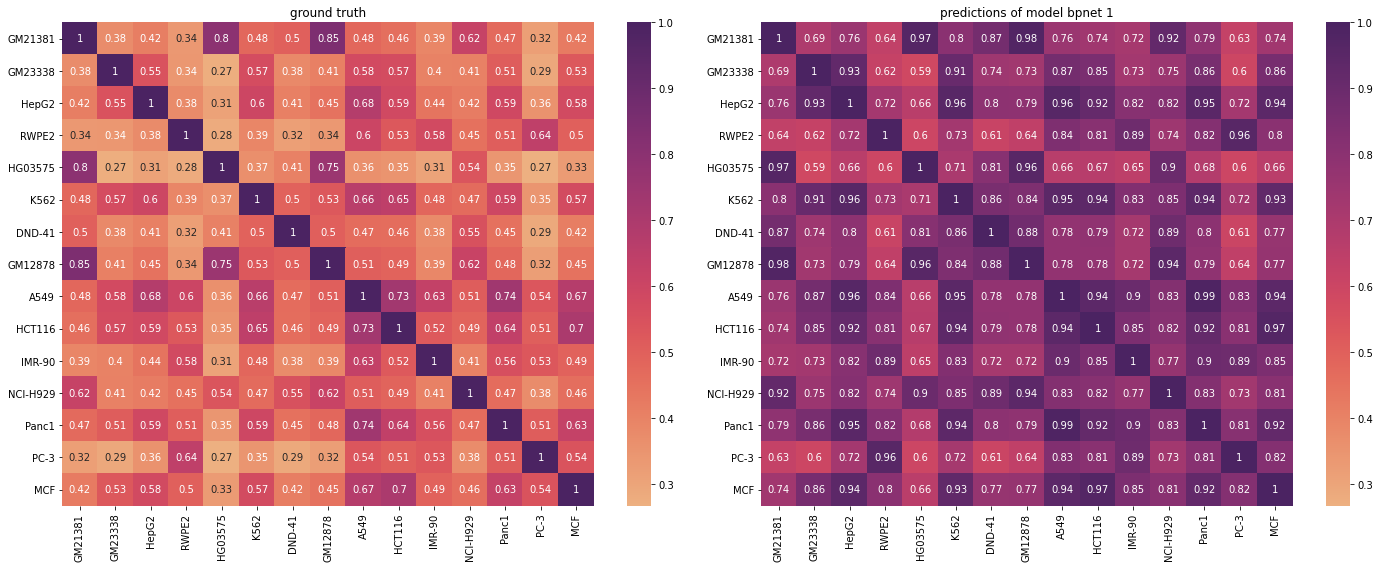

In [23]:
bpnet = 'paper_runs/bpnet/augmentation_48/run-20211006_033330-jyaynmpo'
plot_model_corr(bpnet, testset_path)

Average prediction correlation = 0.8457202570796841


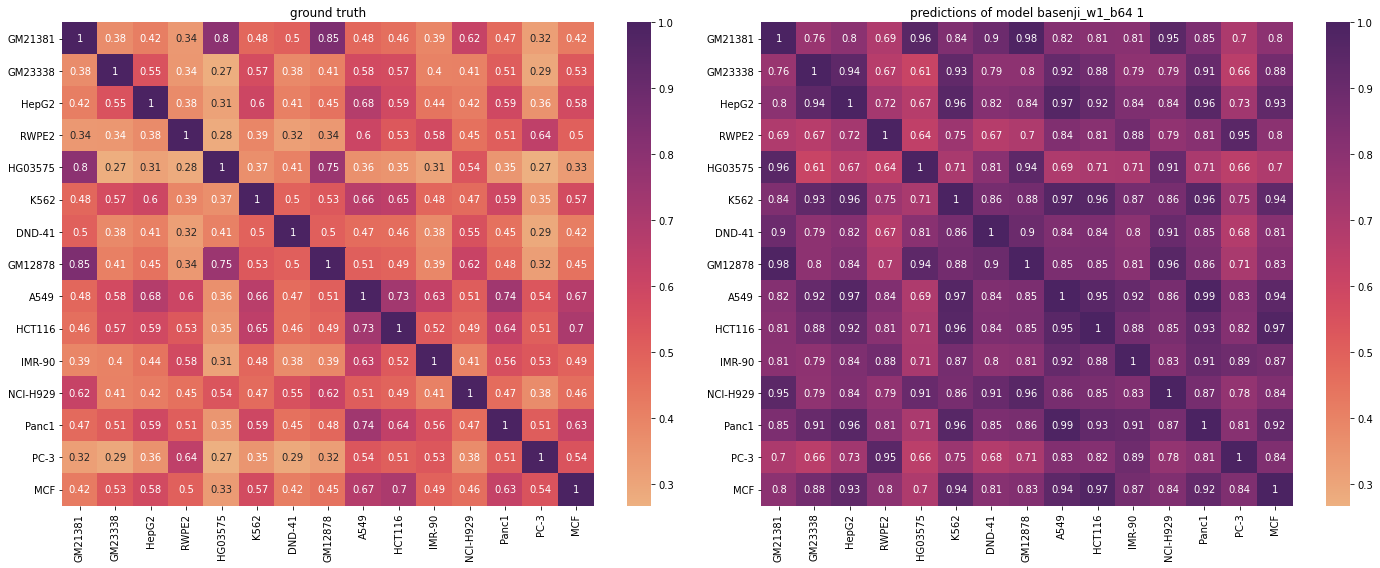

In [24]:
basenji = 'paper_runs/basenji/augmentation_basenji/run-20210925_100205-2ix9rvge'
plot_model_corr(basenji, testset_path)

In [32]:
testset, targets = tfr_evaluate.collect_whole_testset('/mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/shush/4grid_atac/complete/peak_centered/i_2048_w_1/')
basenji_path = 'paper_runs/basenji/augmentation_basenji/run-20210925_100205-2ix9rvge'
bpnet_path = 'paper_runs/bpnet/augmentation_48/run-20211006_033330-jyaynmpo'

In [38]:
both_preds = []
for model_path in [basenji_path, bpnet_path]:
    model, bin_size = tfr_evaluate.read_model(model_path, compile_model=False)
    truth, pred = tfr_evaluate.get_true_pred(model, bin_size, testset)
    pred = tfr_evaluate.change_resolution(pred, 1, 128)
    both_preds.append(pred.flatten())

In [39]:
from scipy.stats import pearsonr

In [40]:
pearsonr(both_preds[0], both_preds[1])

(0.8395483714706113, 0.0)